# Práctica 7

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Descripción-de-un-modelo-de-Markov-con-gaussianas" data-toc-modified-id="Descripción-de-un-modelo-de-Markov-con-gaussianas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Descripción de un modelo de Markov con gaussianas</a></span><ul class="toc-item"><li><span><a href="#Probabilidad-de-cada-conjunto" data-toc-modified-id="Probabilidad-de-cada-conjunto-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Probabilidad de cada conjunto</a></span></li><li><span><a href="#Recursión-alfa" data-toc-modified-id="Recursión-alfa-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Recursión alfa</a></span></li><li><span><a href="#Recursión-beta" data-toc-modified-id="Recursión-beta-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Recursión beta</a></span></li><li><span><a href="#Recursión-gamma" data-toc-modified-id="Recursión-gamma-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Recursión gamma</a></span></li><li><span><a href="#Recursión-psi" data-toc-modified-id="Recursión-psi-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Recursión psi</a></span></li></ul></li><li><span><a href="#Estimando-modelos-en-base-a-EM" data-toc-modified-id="Estimando-modelos-en-base-a-EM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Estimando modelos en base a EM</a></span></li><li><span><a href="#Algoritmo-de-Viterbi" data-toc-modified-id="Algoritmo-de-Viterbi-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Algoritmo de Viterbi</a></span></li></ul></div>

In [1]:
%matplotlib inline
from scipy import io
from scipy import stats as sd
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors as mcolors
from matplotlib.patches import Ellipse
rcParams['figure.figsize'] = (8.0, 4.0)

from time import sleep
from scipy.linalg import sqrtm

# Specification of some HMMs for classification

class hmm:
    def __init__(self,means,vrs,trans):
        self.means = means
        self.vrs = vrs
        self.trans = trans
        
        self.dim = means.shape[1]
        self.numStates = means.shape[0] + 2
        self.devs = np.array([sqrtm(M) for M in vrs])
     
    
def genhmm(hmm):

    stateSeq = [0]
    while stateSeq[-1] != hmm.numStates-1:
        stateSeq.append(int(np.random.choice(hmm.numStates, 1, p=hmm.trans[stateSeq[-1],:])))

    stateSeq = np.array(stateSeq)
    x=np.zeros(((len(stateSeq))-2,hmm.dim))
    for i in range(1,len(stateSeq)-1):
        x[i-1,:] = np.random.multivariate_normal(hmm.means[stateSeq[i]-1],hmm.vrs[stateSeq[i]-1])
    
    return x, stateSeq


def plotseq(hmm, stateSeq, x):
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    classes_names = np.array(['Fonema '+str(i+1) for i in range(hmm.numStates-2)],dtype=object)
    colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).values())

    ax1.plot(x[:,0])
    ax2.plot(x[:,1])

    s = stateSeq[1:-1]-1
    for i in range(hmm.numStates-2):
        mask = s==i
        ax1.scatter(np.arange(s.size)[mask],x[mask,0],color=colors[i],label=classes_names[i])
        ax2.scatter(np.arange(s.size)[mask],x[mask,1],color=colors[i],label=classes_names[i])

    ax1.legend()
    
    return ax1, ax2
    
    
def plotseq2(hmm,stateSeq,x,gauss=False):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    classes_names = np.array(['Fonema '+str(i+1) for i in range(hmm.numStates-2)],dtype=object)
    colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).values())

    ax.plot(x[:,0],x[:,1])
    
    for i in range(x.shape[0]):
        ax.annotate(str(i+1),(x[i,0],x[i,1]))
    

    s = stateSeq[1:-1]-1
    for i in range(hmm.numStates-2):
        mask = s==i
        ax.scatter(x[mask,0],x[mask,1],color=colors[i],label=classes_names[i])
        if gauss:
            mean = x[mask,:].mean(axis=0)
            cov = np.cov(x[mask,:].T)
            covariance_ellipse(mean,cov,ax=ax,color=colors[i])
        
    ax.legend()
    
    return ax
    
    
def covariance_ellipse(mu, sigma, ax=None, color="k"):
    
    # Cálculo de los autovalores:
    vals, vecs = np.linalg.eigh(sigma)
    
    # Inclinación de la elipse:
    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    # Semiejes de la elipse:
    w, h = 2 * np.sqrt(vals)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
                
    ax.tick_params(axis='both', which='major', labelsize=20)
    ellipse = Ellipse(mu, w, h, theta, color=color)
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(0.2)
    ax.add_artist(ellipse)
    
    return ax

# funcion que calcula suma de logaritmos
def logsum(logv):
    leng = len(logv);
    if (leng<2):
        error('Subroutine logsum cannot sum less than 2 terms.')


    # First two terms
    if (logv[1]<logv[0]):
        result = logv[0] + np.log( 1 + np.exp( logv[1]-logv[0] ) )
    else:
        result = logv[1] + np.log( 1 + np.exp( logv[0]-logv[1] ) )


    # Remaining terms
    for i in range(2,leng):
        term = logv[i]
        if result < term:
            result = term   + np.log( 1 + np.exp( result-term ) )
        else:
            result = result + np.log( 1 + np.exp( term-result ) )
            
    return result



def logfwd(*args,**kwargs):
    """LOGFWD Log version of the forward procedure

    LOGPROB = LOGFWD(X,MEANS,VARS,TRANSITIONS) returns the likelihood of
    the 2-dimensional sequence X (one observation per row) with respect to
    a Markov model with N states having means MEANS and variances VARS
    (stored in N elements lists with empty matrices as first and last
    elements to symbolize the entry and exit states) and transition matrix
    TRANSITIONS.
      Alternately, LOGFWD(X,HMM) can be used, where HMM is an object of the
    form:
       HMM.means = MEANS;
       HMM.vars = VARS;
       HMM.trans = TRANSITIONS"""
    if len(args)==2:
        x=args[0]
        means=args[1].means
        vrs=args[1].vrs
        trans=args[1].trans
    else:
        x=args[0]
        means=args[1]
        vrs=args[2]
        trans=args[3]
    
    trans[trans<1e-100]=1e-100
    logtrans=np.log(trans)
    
    numstates=len(means)
    I=np.arange(1,numstates+1)
    [numpts,dim]=np.shape(x)
    
    invsigs=np.zeros((dim,dim))
    logdetvars2=0
    log2pi=np.log(2*np.pi)
    for i in I-1:
        invsig=np.linalg.inv(vrs[i])
        invsigs=np.dstack((invsigs,invsig))
        logdet= - 0.5 * np.log(np.linalg.det(vrs[i])) - log2pi
        logdetvars2 = np.hstack((logdetvars2,logdet))
        
    # Initialize the alpha vector for the emitting states
    alpha_t=0
    for i in I:
        X=x[0,:]-means[i-1].T
        alph=logtrans[0,i] - .5 * (np.dot(np.dot(X,invsigs[:,:,i]),X.T) )+ logdetvars2[i]
        alpha_t=np.hstack((alpha_t,alph))
    alpha=alpha_t
    
    # Do the forward recursion
    for t in range(1, numpts):
        alphabefore=np.copy(alpha_t)
        alpha_t=0
        for i in I:
            X=x[t,:]-means[i-1].T
            alph=logsum(alphabefore[I] + logtrans[I,i]) - .5 * (np.dot(np.dot(X,invsigs[:,:,i]),X.T)) + logdetvars2[i]
            alpha_t=np.hstack((alpha_t,alph))
        alpha=np.hstack((alpha,alpha_t))
        
    logprob =  logsum( alpha_t[I] + logtrans[I,numstates+1] )
    alpha = alpha.reshape(numpts, numstates+1)
    return logprob, alpha

def graficar(x,gamma,ll,means,vrs):
    fig, ax1 = plt.subplots()
    covariance_ellipse(means[0],vrs[0],ax1,'b')
    covariance_ellipse(means[1],vrs[1],ax1,'r')
    covariance_ellipse(means[2],vrs[2],ax1,'g')
    ax1.scatter(x[:,0],x[:,1],c=gamma[:,(2,3,1)])
    ax1.plot(means[0,0],means[0,1],'-s',color='xkcd:blue')
    ax1.plot(means[1,0],means[1,1],'-s',color='xkcd:dark pink')
    ax1.plot(means[2,0],means[2,1],'-s',color='xkcd:olive green')
    # Formato
    ax1.set_title('Log likelihood = %d'%ll)
    #ax1.set_xlim([200,1200])
    #ax1.set_ylim([600,1600])
    ax1.set_xlabel('Formante 1 [Hz]')
    ax1.set_ylabel('Formante 2 [Hz]')


def logpdfnorm(mu,sigma,x):
    """
    
        Evaluación de los puntos x en K gaussianas de medias mu y varianzas sigma.
        
        mu: (K,d) array que contiene las medias de las gaussianas en las filas.
        sigma: (K,d,d) array que contiene las matrices de covarianzas de las gaussianas.
        x: (N,d) array que contiene los lugares en donde evaluar las gaussianas.
        
        return: (N,K) array con los valores de la normal en los puntos x
    """
        
    d = x.shape[1]
    x_unbiased = x - mu[:,np.newaxis]
    sigma_inv = np.linalg.inv(sigma)
    y = - (d/2) * np.log(2*np.pi) - .5 * np.log(np.linalg.det(sigma)) - .5 * np.einsum('ijk,ijk->ij',np.matmul(x_unbiased,sigma_inv),x_unbiased).T

    return y

# Algoritmo de Viterbi:

def logvit(X,hmm):
    
    T = X.shape[0] # Cantidad de mediciones
    N = hmm.numStates - 2 # Cantidad de estados sin contar el final y el inicial
    zero = 1e-100 # Valor mínimo para evitar división por cero
    
    # Evaluación del logaritmo de la normal 
    log_b = logpdfnorm(hmm.means,hmm.vrs,X)
        
    # Matriz de transición para la recursión
    log_trans = hmm.trans[1:-1,1:-1].copy()
    log_trans[log_trans<zero] = zero
    np.log(log_trans, out=log_trans)
    
    # Inicialización del log_phi
    log_phi = np.zeros((N,T),dtype=np.float)
    log_phi0 = hmm.trans[0,1:-1].copy()
    log_phi0[log_phi0<zero] = zero
    np.log(log_phi0, out=log_phi0)
    log_phi[:,0] = log_b[0,:] + log_phi0
    
    # Inicialización del log_psi
    log_psi = np.ones((N,T),dtype=np.int)

    # Recursión forward
    for i in range(1,T):        
        m = log_trans + log_phi[:,i-1].reshape(N,1)
        log_psi[:,i] = np.argmax(m,axis=0)
        log_phi[:,i] = log_b[i,:] + np.max(m,axis=0)
    
    # Terminación:
    seqOpt = np.ones(T,dtype=np.int)
    seqOpt[-1] = np.argmax(log_phi[:,-1])    
    costOpt = log_phi[seqOpt[-1],-1].copy()
    
    # Backtracking:
    for i in range(T-1,0,-1):
        seqOpt[i-1] = log_psi[seqOpt[i],i].copy()
                
    return costOpt, np.hstack((0,seqOpt+1,hmm.numStates-1))

## Descripción de un modelo de Markov con gaussianas

In [2]:
# Carga de datos

# GENDATA Generation of simulation data for HMM lab

# Specification of simulated vowels statistics
Pa = 0.25
mu_a = np.array([730., 1090.])
std_a = np.array([[35.,  20.],
                  [20.,  230.]])
var_a = std_a.dot(std_a)

Pe = 0.3
mu_e = np.array([530., 1840.])
std_e = np.array([[120.,  25.],
                  [25.,  190.]])
var_e = std_e.dot(std_e)

Pi = 0.25
mu_i = np.array([270., 2290.])
std_i = np.array([[50.,  5.],
                  [5.,  190.]])
var_i = std_i.dot(std_i)

Po = 0.15
mu_o = np.array([570., 840.])
std_o = np.array([[40.,  20.],
                  [20.,  140.]])
var_o = std_o.dot(std_o)

Py = 0.05
mu_y = np.array([440., 1020.])
std_y = np.array([[80.,  40.],
                  [40.,  130.]])
var_y = std_y.dot(std_y)

        
# 1: ergodic /aiy/, "unstable"
means = np.stack((mu_a,mu_i,mu_y))
vrs = np.stack((var_a,var_i,var_y))
trans = np.array([[0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.4, 0.3, 0.3, 0.0],
                  [0.0, 0.3, 0.4, 0.3, 0.0],
                  [0.0, 0.3, 0.3, 0.3, 0.1],
                  [0.0, 0.0, 0.0, 0.0, 1.0]])

hmm1 = hmm(means, vrs, trans)

# 2: ergodic /aiy/, "stable"
means = np.stack((mu_a,mu_i,mu_y))
vrs = np.stack((var_a,var_i,var_y))
trans = np.array([[0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.95, 0.025, 0.025, 0.0],
                  [0.0, 0.025, 0.95, 0.025, 0.0],
                  [0.0, 0.02, 0.02, 0.95, 0.01],
                  [0.0, 0.0, 0.0, 0.0, 1.0]])

hmm2 = hmm(means, vrs, trans)

# 3: left-right /aiy/, unstable
means = np.stack((mu_a,mu_i,mu_y))
vrs = np.stack((var_a,var_i,var_y))
trans = np.array([[0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.5, 0.5, 0.0, 0.0],
                  [0.0, 0.0, 0.5, 0.5, 0.0],
                  [0.0, 0.0, 0.0, 0.5, 0.5],
                  [0.0, 0.0, 0.0, 0.0, 1.0]])

hmm3 = hmm(means, vrs, trans)

# 4: left-right /aiy/, stable
means = np.stack((mu_a,mu_i,mu_y))
vrs = np.stack((var_a,var_i,var_y))
trans = np.array([[0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.95, 0.05, 0.0, 0.0],
                  [0.0, 0.0, 0.95, 0.05, 0.0],
                  [0.0, 0.0, 0.0, 0.95, 0.05],
                  [0.0, 0.0, 0.0, 0.0, 1.0]])

hmm4 = hmm(means, vrs, trans)

# 5: left-right /yia/, stable
means = np.stack((mu_y,mu_i,mu_a))
vrs  = np.stack((var_y,var_i,var_a))
trans = np.array([[0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.95, 0.05, 0.0, 0.0],
                  [0.0, 0.0, 0.95, 0.05, 0.0],
                  [0.0, 0.0, 0.0, 0.95, 0.05],
                  [0.0, 0.0, 0.0, 0.0, 1.0]])

hmm5 = hmm(means, vrs, trans)

# 6: left-right /aie/, stable
means = np.stack((mu_a,mu_i,mu_e))
vrs  = np.stack((var_a,var_i,var_e))
trans = np.array([[0.0, 1.0,  0.0,  0.0,  0.0],
                  [0.0, 0.95, 0.05, 0.0,  0.0],
                  [0.0, 0.0,  0.95, 0.05, 0.0],
                  [0.0, 0.0,  0.0,  0.95, 0.05],
                  [0.0, 0.0,  0.0,  0.0,  1.0]]);

hmm6 = hmm(means, vrs, trans)

# 7: left-right /aiy/, stable w/ unequal stay probas
means = np.stack((mu_a,mu_i,mu_y))
vrs  = np.stack((var_a,var_i,var_y))
trans = np.array([[0.0, 1.0,  0.0,  0.0,  0.0],
                  [0.0, 0.7,  0.3,  0.0,  0.0],
                  [0.0, 0.0,  0.95, 0.05, 0.0],
                  [0.0, 0.0,  0.0,  0.7,  0.3],
                  [0.0, 0.0,  0.0,  0.0,  1.0]])

hmm7 = hmm(means, vrs, trans)



from scipy.io import loadmat
x = loadmat('data.mat')
X1, X2, X3, X4, X5, X6 = x['X1'], x['X2'], x['X3'], x['X4'], x['X5'], x['X6']
ST1, ST2, ST3, ST4, ST5, ST6 = x['ST1'].astype(np.int)[0]-1, x['ST2'].astype(np.int)[0]-1, x['ST3'].astype(np.int)[0]-1, x['ST4'].astype(np.int)[0]-1, x['ST5'].astype(np.int)[0]-1, x['ST6'].astype(np.int)[0]-1

(<matplotlib.axes._subplots.AxesSubplot at 0x7f578c24b898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f578c1f7588>)

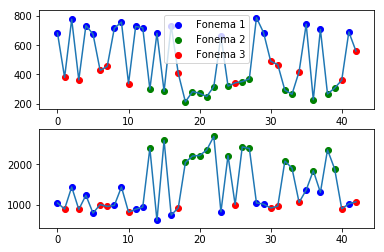

In [3]:
plotseq(hmm1, ST1,X1)

### Probabilidad de cada conjunto

In [4]:
# aca tenes que hacer un ciclo calculando la probabilidad de las observaciones y sus estados
# y ver como cambia si se usa un hmm incorrecto
# hay que tenerlo hecho para el lunes
# tengo que hacer la productoria de P(yt|qt)*P(qt|qt-1)
# si uso logaritmos es todo una suma
# P(yt|qt) es una normal
# P(qt|qt-1) esta determinada por la matriz de transicion
def prob_conjunta(muestras,estados,modelo):
    means=modelo.means
    vrs=modelo.vrs
    logtrans=np.copy(modelo.trans)
    logtrans[logtrans<1e-100]=1e-100
    num_obs= len(muestras)
    prob_conj=0
    for t in range(2,num_obs):
        logprob_yq = sd.multivariate_normal.logpdf(muestras[t],means[int(estados[t+1])-1],vrs[int(estados[t+1])-1])
        logprob_qq = logtrans[int(estados[t]),int(estados[t+1])]
        prob_conj=prob_conj+logprob_yq+logprob_qq
    return prob_conj

i=1
maximo=-1e100
imax=0
for hmm_test in (hmm1,hmm2,hmm3,hmm4,hmm5,hmm6):
    P=prob_conjunta(X6,ST6,hmm_test)
    if maximo<P:
        maximo=np.copy(P)
        imax=np.copy(i)
    i+=1
print(maximo,imax,'\n')

# de correr esto, el modelo 1 es el que caracteriza al conjunto de muestras y estados 1
# el modelo 4 es el que caracteriza el conjunto 2
# el modelo 5 es el que caracteriza el conjunto 3
# el modelo 4 es el que caracteriza el conjunto 4
# el modelo 6 es el que caracteriza el conjunto 5
# el modelo 2 es el que caracteriza el conjunto 6

-1176.9774275779412 2 



### Recursión alfa

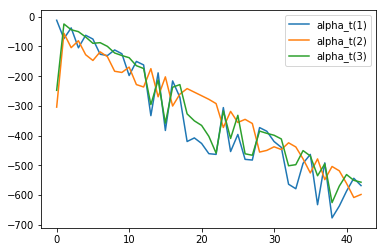

In [5]:
# Para calcular los terminos de la recursión alfa se modifico la función logfwd para que devuelva,
# ademas de la probabilidad de la observación, los alfa en cada instante T.
prob_obs,alpha=logfwd(X1,hmm1)
fig,ax=plt.subplots()
ax.plot(alpha[:,1])
ax.plot(alpha[:,2])
ax.plot(alpha[:,3])
ax.legend(('alpha_t(1)','alpha_t(2)','alpha_t(3)'))

### Recursión beta

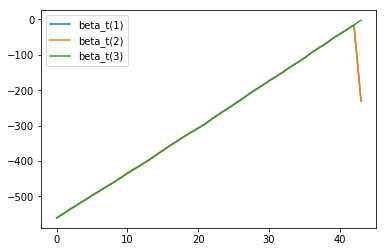

In [6]:
# Para calcular la recursión beta voy a tener que definir una nueva función
def logbeta(*args,**kwargs):
    """Calcula los beta para un dado modelo de cadenas de markov ocultas.
    Toma x y un hmm o x, medias, varianzas y transiciones."""
    if len(args)==2:
        x=args[0]
        means=args[1].means
        vrs=args[1].vrs
        trans=args[1].trans
    else:
        x=args[0]
        means=args[1]
        vrs=args[2]
        trans=args[3]
    
    trans[trans<1e-100]=1e-100
    logtrans=np.log(trans)
    
    numstates=len(means)
    [numpts,dim]=np.shape(x)
    
    #beta inicial
    beta=np.hstack((0,logtrans[1:-1,-1]))
    
    #betas siguientes
    T=np.arange(0,numpts)
    T=T[::-1]
    I=np.arange(numstates)
    beta_t=np.copy(beta)
    bj=0
    for i in I:
        b=sd.multivariate_normal.logpdf(x[-1],means[i],vrs[i])
        bj=np.hstack((bj,b))
        
    for t in T:
        beta_before=np.copy(beta_t)
        beta_t=0
        bj_before=np.copy(bj)
        bj=0
        for i in I:
            bet=logsum(beta_before[I+1]+logtrans[i+1,I+1]+bj_before[I+1])
            b=sd.multivariate_normal.logpdf(x[t],means[i],vrs[i])
            bj=np.hstack((bj,b))
            beta_t=np.hstack((beta_t,bet))
        beta=np.hstack((beta,beta_t))
    beta=beta.reshape(numpts+1,numstates+1)
    beta=beta[::-1,:]
    return beta

prob_obs,alpha=logfwd(X1,hmm1)
beta=logbeta(X1,hmm1)
fig,ax=plt.subplots()
ax.plot(beta[:,1])
ax.plot(beta[:,2])
ax.plot(beta[:,3])
ax.legend(('beta_t(1)','beta_t(2)','beta_t(3)'))


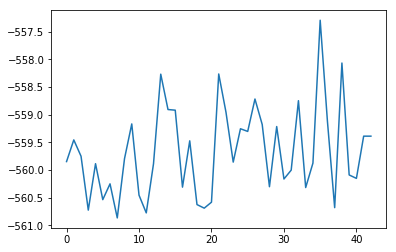

In [7]:
# Probabilidad del conjunto
prob=0
for i in range(len(alpha)):
    prob=np.hstack((prob,logsum(alpha[i,1:]+beta[i+1,1:])))
fig,ax=plt.subplots()
ax.plot(prob[1:])

In [8]:
indice=np.random.choice(len(alpha))
print('La probabilidad de la observación es ',prob_obs,
      '\nCalculando con alpha y beta en ',indice,', me da',logsum(alpha[indice,1:]+beta[indice+1,1:]))

La probabilidad de la observación es  -559.387887778169 
Calculando con alpha y beta en  31 , me da -560.002405513425


### Recursión gamma

0.0

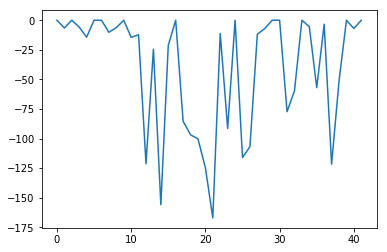

In [9]:
def loggamma(alpha,beta):
    prob=0
    for i in range(len(alpha)):
        prob=np.hstack((prob,logsum(alpha[i,1:]+beta[i+1,1:])))
    gamma=alpha+beta[1:,:]-np.hstack((np.zeros((len(prob)-1,1)),prob[1:,np.newaxis]*np.ones((1,3))))
    #print(np.shape(gamma))
    #gamma=np.hstack((0,gamma))
    return gamma

gamma=loggamma(alpha,beta)

fig,ax=plt.subplots()
ax.plot(gamma[1:,3])

logsum(gamma[27,1:])

### Recursión psi

In [10]:
def logpsi(alpha,beta,hmm,x):
    means=hmm.means
    vrs=hmm.vrs
    trans=hmm.trans
    trans[trans<1e-100]=1e-100
    logtrans=np.log(trans)
    
    prob=0
    for t in range(len(alpha)):
        prob=np.hstack((prob,logsum(alpha[t,1:]+beta[t+1,1:])))
        
    psi=np.zeros((3,3))
    for t in np.arange(len(alpha)-1):
        psi_t=np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                psi_t[i,j]=alpha[t,i+1]+beta[t+2,j+1]+logtrans[i+1,j+1]+sd.multivariate_normal.logpdf(x[t+1],means[j],vrs[j])
        psi_t=psi_t-prob[t+1]
        psi=np.dstack((psi,psi_t))
    return psi

psi=logpsi(alpha,beta,hmm1,X1)
a11=logsum(psi[0,0,1:])-logsum(gamma[1:,1])
a22=logsum(psi[1,1,1:])-logsum(gamma[1:,2])
a33=logsum(psi[2,2,1:])-logsum(gamma[1:,3])
print(psi[:,:,40],hmm1.trans[1:4,1:4],np.exp((a11,a22,a33)))



[[-1.74332290e+02 -1.48743608e+02 -1.18745800e+02]
 [-5.59361702e+01 -2.97721244e+01 -6.19976091e-02]
 [-1.07457899e+02 -8.15815357e+01 -5.15837268e+01]] [[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.3]] [0.52072738 0.91252288 0.14829124]


## Estimando modelos en base a EM

In [11]:
# Generacion de los datos
np.random.seed(958151264)
uno = 0
dos = 0
tres = 0
while uno < 10 or dos < 10 or tres < 10:
    X, stateSeq = genhmm(hmm6)
    uno = (stateSeq==1).sum()
    dos = (stateSeq==2).sum()
    tres = (stateSeq==3).sum()

np.savez('./X_ST.npz',x=X,y=stateSeq)



0
1
2
3
4
5


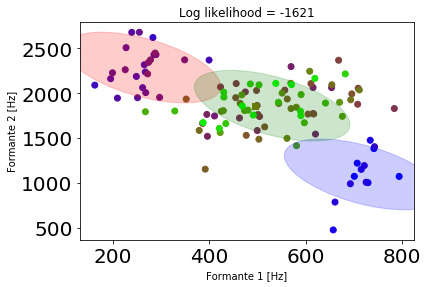

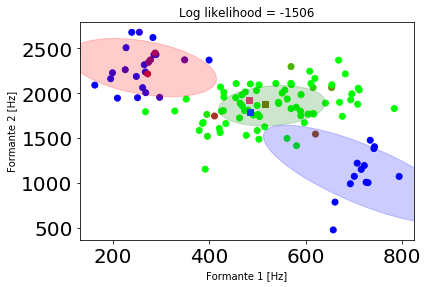

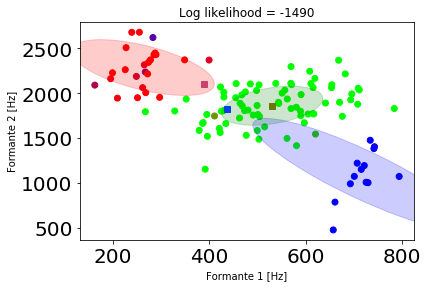

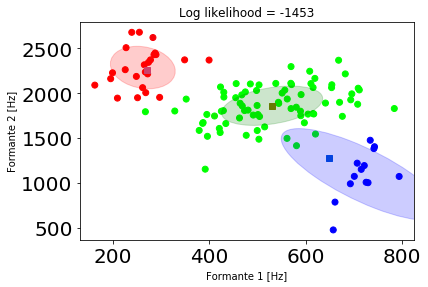

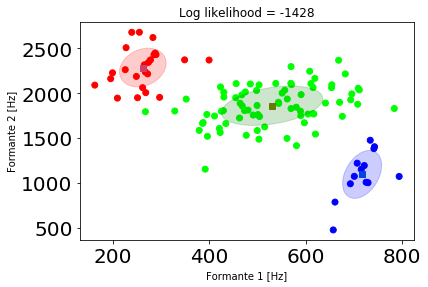

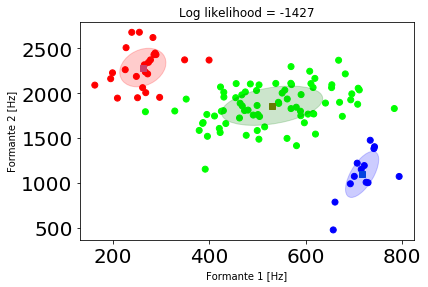

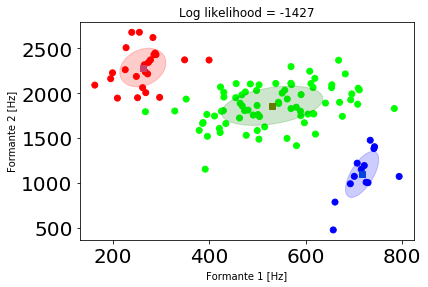

In [12]:
# Funcion que calcula alpha beta gamma y psi
# Hice una nueva función para no recalcular las gausianas tantas veces
def alphabetagammapsill(*args,**kwargs):
    if len(args)==2:
        x=args[0]
        means=args[1].means
        vrs=args[1].vrs
        trans=args[1].trans
    else:
        x=args[0]
        means=args[1]
        vrs=args[2]
        trans=args[3]
    
    trans[trans<1e-100]=1e-100
    logtrans=np.log(trans)
    
    numstates=len(means)
    [numpts,dim]=np.shape(x)
    T=np.arange(1,numpts)
    I=np.arange(numstates)
    # matriz B
    invsigs=np.zeros((numstates,dim,dim))
    log2pi=np.log(2*np.pi)
    logdetvars2=np.zeros((numstates,1))
    for i in I:
        invsigs[i]=np.linalg.inv(vrs[i])
        if np.linalg.det(vrs[i])<0:
            print('determinante < 0')
        logdetvars2[i] = - 0.5 * np.log(np.linalg.det(vrs[i])) - log2pi
        
    B=np.zeros((numpts,numstates))
    for t in np.arange(numpts):
        for i in np.arange(numstates):
            x_insesgado=x[t,:]-means[i].T
            B[t,i]=- .5 * (np.dot(np.dot(x_insesgado,invsigs[i]),x_insesgado.T)) + logdetvars2[i]
    
    #alfa inicial
    alpha=np.hstack((0,logtrans[0,I+1]))
    alpha[I+1] = alpha[I+1] + B[0,:]
    #alfas siguientes
    alpha_t=np.copy(alpha)
    for t in T:
        alphabefore=np.copy(alpha_t)
        alpha_t=0
        for i in I:
            alph=logsum(alphabefore[I+1] + logtrans[I+1,i+1]) + B[t,i]
            alpha_t=np.hstack((alpha_t,alph))
        alpha=np.hstack((alpha,alpha_t))
    logprob =  logsum( alpha_t[I+1] + logtrans[I+1,numstates+1] )
    alpha = alpha.reshape(numpts, numstates+1)
        
    #beta inicial
    beta=np.hstack((0,logtrans[1:-1,-1]))
    #betas siguientes
    T=np.arange(0,numpts)
    T=T[::-1]
    beta_t=np.copy(beta)  
    for t in T:
        beta_before=np.copy(beta_t)
        beta_t=0
        for i in I:
            bet=logsum(beta_before[I+1]+logtrans[i+1,I+1]+B[t,I])
            beta_t=np.hstack((beta_t,bet))
        beta=np.hstack((beta,beta_t))
    beta=beta.reshape(numpts+1,numstates+1)
    beta=beta[::-1,:]
    
    #probabilidad de la observacion
    prob=0
    for i in range(len(alpha)):
        prob=np.hstack((prob,logsum(alpha[i,1:]+beta[i+1,1:])))
        
    #gamma
    gamma=alpha+beta[1:,:]-np.hstack((np.zeros((len(prob)-1,1)),prob[1:,np.newaxis]*np.ones((1,3))))
    
    #psi
    psi=np.zeros((3,3))
    for t in np.arange(len(alpha)-1):
        psi_t=np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                psi_t[i,j]=alpha[t,i+1]+beta[t+2,j+1]+logtrans[i+1,j+1]+B[t+1,j]
        psi_t=psi_t-prob[t+1]
        psi=np.dstack((psi,psi_t))
    
    return alpha,beta,gamma,psi,logprob

#--------------#
# Algoritmo EM #
#--------------#
data = np.load('./X_ST.npz')
X = data['x'] # Muestras
ST = data['y'] # Secuencia temporal
#Inicialización
numstates=3
I=np.arange(numstates)
[numpts,dim]=np.shape(X)
means=np.sum(X,axis=0)/numpts
means=np.dot(np.ones((numstates,1)),means[np.newaxis,:])
sigma=np.dot(X.T,X)/numpts - np.dot(means[2,np.newaxis].T,means[2,np.newaxis])
vrs= np.stack((sigma,sigma,sigma))
trans=np.array([[0, 1, 0, 0, 0],
                [0, 1/2, 1/2, 0, 0],
                [0, 0, 1/2, 1/2, 0],
                [0, 0, 0, 1/2, 1/2],
                [0, 0, 0, 0, 1]])

alpha,beta,gamma,psi,ll=alphabetagammapsill(X, means, vrs, trans)
graficar(X,np.exp(gamma),ll,means,vrs)
ll_ant = ll - 1000
iteraciones=0
while ll-ll_ant>1e-6:
    #normalizacion
    norm=np.zeros((numstates,1))
    for i in I:
        norm[i]=logsum(gamma[:,i+1])
        norm[i]=np.exp(norm[i])
    #medias
    for i in I:
        # logaritmico
        #aux = np.copy(X3)
        #aux[aux<1e-100] = 1e-100
        #aux = np.log(aux)
        #aux = aux + np.dot( gamma[:,i+1,np.newaxis], np.ones((1,2)) )
        #means[i,0] = np.exp(logsum(aux[:,0]) - norm[i])
        #means[i,1] = np.exp(logsum(aux[:,1]) - norm[i])
        
        # en valor absoluto
        means[i] = np.dot(X.T,np.exp(gamma[:,i+1,np.newaxis])).T / norm[i]
    #varianzas
    for i in I:
        # logaritmico
        #aux = X3-means[i]
        #aux[aux<1e-100] = 1e-100
        #aux = np.log(aux)
        #aux2 = aux + np.dot(gamma[:,i+1,np.newaxis] , np.array([[1, 1]]))    
        #a11 = logsum(aux2[:,0]+aux[:,0]) - norm[i]
        #a22 = logsum(aux2[:,1]+aux[:,1]) - norm[i]
        #a21 = logsum(aux2[:,1]+aux[:,0]) - norm[i]
        #a12 = logsum(aux2[:,0]+aux[:,1]) - norm[i]
        #vrs[i] = np.reshape(np.hstack((a11,a12,a21,a22)),(2,2))
        #vrs[i] = np.exp(vrs[i])
        
        # en valor absoluto
        aux = np.dot(np.exp(gamma[:,i+1,np.newaxis]) , np.ones((1,dim))) * (X-means[i])
        vrs[i]= np.dot(aux.T, X-means[i]) / norm[i]
    #trans
    for i in I:
        for j in I:
            trans[i+1,j+1]=logsum(psi[i,j,1:])-np.log(norm[i])
    trans[1:-1,1:-1]=np.exp(trans[1:-1,1:-1])
    trans[1:-1,-1]=1-np.sum(trans[1:-1,1:-1],axis=1)
    
    
    ll_ant=np.copy(ll)
    alpha,beta,gamma,psi,ll=alphabetagammapsill(X, means, vrs, trans)
    print(iteraciones)
    iteraciones=iteraciones+1
    graficar(X,np.exp(gamma),ll,means,vrs)
    





No entiendo muy bien por qué en el gráfico las elipses me aparecen sobre la última media.
## Algoritmo de Viterbi

In [13]:
# Generacion de un modelo conjunto
means=np.vstack((hmm4.means,hmm6.means))
vrs=np.vstack((hmm4.vrs,hmm6.vrs))
trans=np.zeros((hmm4.numStates+hmm6.numStates-2,hmm4.numStates+hmm6.numStates-2))
#prob de modelo inicial
trans[0,1]=.5
trans[0,hmm4.numStates]=.5
#transiciones estado propias de cada hmm simple
trans[1:hmm4.numStates,1:hmm4.numStates]=hmm4.trans[1:,1:]
trans[hmm4.numStates-1:,hmm4.numStates-1:]=hmm6.trans[1:,1:]
# transiciones al estado final o al otro hmm
# en hmm4
p=trans[hmm4.numStates-1,hmm4.numStates]
trans[hmm4.numStates-1,hmm4.numStates]=p*2/3
trans[hmm4.numStates-1,-1]=p*1/3
# en hmm6
p=trans[-2,-1]
trans[-2,-1]=p*1/3
trans[-2,1]=p*2/3

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(trans)


hmm46 = hmm(means,vrs,trans)

[[0.    0.5   0.    0.    0.    0.5   0.    0.   ]
 [0.    0.95  0.05  0.    0.    0.    0.    0.   ]
 [0.    0.    0.95  0.05  0.    0.    0.    0.   ]
 [0.    0.    0.    0.95  0.05  0.    0.    0.   ]
 [0.    0.    0.    0.    0.95  0.033 0.    0.017]
 [0.    0.    0.    0.    0.    0.95  0.05  0.   ]
 [0.    0.033 0.    0.    0.    0.    0.95  0.017]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [14]:
# Así se generaron las secuencias de observaciones y de estados
# del modelo conjunto. (SE RECOMIENDA NO DESCOMENTAR ESTA CELDA.)

#uno = 0
#dos = 0
#tres = 0
#cuatro = 0
#cinco = 0
#seis = 0
#NN = 30 
#while uno < NN or dos < NN or tres < NN or cuatro < NN or cinco < NN or seis < NN:
#    X, stateSeq = genhmm(hmm46)
#    uno = (stateSeq==1).sum()
#    dos = (stateSeq==2).sum()
#    tres = (stateSeq==3).sum()
#    cuatro = (stateSeq==4).sum()
#    cinco = (stateSeq==5).sum()
#    seis = (stateSeq==6).sum()

#print(stateSeq)

#np.savez('./X_ST_hmm46.npz',x=X,y=stateSeq)

In [16]:
# Leo los datos generados previamente:
data = np.load('./X_ST_hmm46.npz')
X46 = data['x']
stateSeq46 = data['y']

# Algoritmo de Viterbi:
costOpt, seqOpt = logvit(X46,hmm46)
print('Lugares distintos')
print(seqOpt-stateSeq46)
print('Errores: %d/%d' %(np.sum(seqOpt!=stateSeq46), np.size(stateSeq46)))
index=np.arange(1,np.size(seqOpt))
inicio_hmm4=seqOpt==1
inicio_hmm4=np.diff(inicio_hmm4.astype(int))
inicio_hmm4=inicio_hmm4>0
print('Inicio del hmm4',index[inicio_hmm4])
inicio_hmm6=seqOpt==4
inicio_hmm6=np.diff(inicio_hmm6.astype(int))
inicio_hmm6=inicio_hmm6>0
print('Inicio del hmm6',index[inicio_hmm6])




Lugares distintos
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0